In [1]:
from matplotlib.pyplot import *
import numpy as np
import h5py
from tqdm import tqdm
#from src.algorithms import *
#import torch
import sklearn
import PIL
from PIL import Image
import cv2
%load_ext autoreload


In [2]:
find_index = lambda wavelenghts, w : np.argmin(np.abs(wavelenghts - w))

In [3]:
def Raman_data_loader(filename):

    with h5py.File(filename, 'a') as output_file:
         
        properties = output_file['properties']
        
        exp_properties = {'step_size' : np.array(properties['step_size'])[0],
                          'speed' : np.array(properties['speed']),
                          'n_points' : np.array(properties['n_points'])
            }
        
        wavelengths = np.array(output_file['properties']['x_data'])
        
        
        spot_numbers = [int(s.split('_')[-1]) for s in list(output_file['data'].keys()) if 'spot' in s ]
        
        Nx,Ny = output_file['properties']['n_points'][0], output_file['properties']['n_points'][1]
        Nl = len(wavelengths)
        spectral_signal = np.zeros([Nx,Ny,Nl])
        
        
        for _i, spot_number in enumerate(spot_numbers):

            ix, iy = int(spot_number//Ny), int(spot_number%Ny)
            
            spot = 'spot_'+str(spot_number)
            data = np.array(output_file['data'][spot]['raw_data'])
                      
            spectral_signal[ix,iy,:] = data
            

    return spectral_signal, wavelengths, exp_properties

In [4]:
#filename = "2023913_1110.h5" #original
#filename = "202310 9_1132.h5" #pedras mais pequenas
#filename='202310 9_1420.h5'
filename1='20231130_ 858.h5' #pedra potencia 30%
filename2='20231129_15 9.h5' #pedra potencia 40%
filename3='20231130_1053.h5' #pedra potencia 60%
spectrum_raman_1, wavelengths_raman, exp_properties = Raman_data_loader(filename1) #P=30%
spectrum_raman_2, wavelengths_raman, exp_properties = Raman_data_loader(filename2)# P=40%
spectrum_raman_3, wavelengths_raman, exp_properties = Raman_data_loader(filename3)#P=60%

In [5]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als_optimized(y, lam, p, niter = 10):
    L = len(y)
    D = sparse.diags([1, -2, 1],[0, -1, -2], shape = (L, L - 2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

In [6]:
spectra=np.array([spectrum_raman_1,spectrum_raman_2,spectrum_raman_3])


In [7]:
lam = 1e2
p = 1e-1
pro_data_geral=[]
for spect in spectra:
    spectrum_raman=spect
    pro_data = 1*spectrum_raman
    for i in tqdm(range(0, pro_data.shape[0])):
        for j in range(0, pro_data.shape[1]):
            # print(i,j,end='\r')
            spec = 1 * pro_data[i, j, :]
            pro_data[i, j, :] = spec - baseline_als_optimized(spec, lam = lam, p = p, niter = 10)
    pro_data_geral.append(pro_data)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


In [8]:
pro_data_geral=np.array(pro_data_geral)

In [9]:
pro_data_norm_geral=pro_data_geral.copy()


for spect in range(3):
    for i in range(0,pro_data.shape[0]):
        for j in range(0,pro_data.shape[1]):
            spec = 1 * pro_data_geral[spect,i,j, :]
            sum_spec=np.sum(spec)
            pro_data_norm_geral[spect,i,j,:]=spec/sum_spec

In [10]:
offset_l = 31
offset_m = 328

mask1 = pro_data_norm_geral[0,:, :, offset_l:offset_m]
mask2 = pro_data_norm_geral[1,:, :, offset_l:offset_m]#.reshape(pro_data.shape[0]*pro_data.shape[1], -1)
mask3 = pro_data_norm_geral[2,:, :, offset_l:offset_m]


In [11]:
wavelengths_raman_offset=wavelengths_raman[offset_l:offset_m]

In [12]:
mask_geral=np.array([mask1,mask2,mask3])

In [13]:
mask_min_max_geral=[]
for imagem in mask_geral:
    mask_t = imagem.copy()
    #(mask1_p-mask1_p.min())/(mask1_p.max()-mask1_p.min())
    mask_min_max = np.array([(mask_t[:,:, i] - mask_t[:,:, i].min())/(mask_t[:,:, i].max() - mask_t[:,:,i].min()) for i in range(mask_t.shape[-1])])
    mask_min_max=mask_min_max.reshape(297,5000).T
    mask_min_max_geral.append(mask_min_max)
mask_min_max_geral=np.array(mask_min_max_geral)

In [14]:
def gauss(x, sigma): 
    return  np.exp(-(x-0.5) ** 2 / (2 * sigma ** 2))
sig=0.2
weights=gauss(mask_min_max_geral,sig)

## considerar a foto com mais peso

In [15]:
final_mask=np.zeros([5000, 297])
for i in tqdm(range(0,weights.shape[1])):
    for k in range(weights.shape[2]):
        arg=np.argmax(weights[:,i,k])
        final_mask[i,k]=mask_min_max_geral[arg,i,k] 
        

100%|██████████| 5000/5000 [00:05<00:00, 960.19it/s] 


In [16]:
final_mask=final_mask.reshape(100,50,-1)

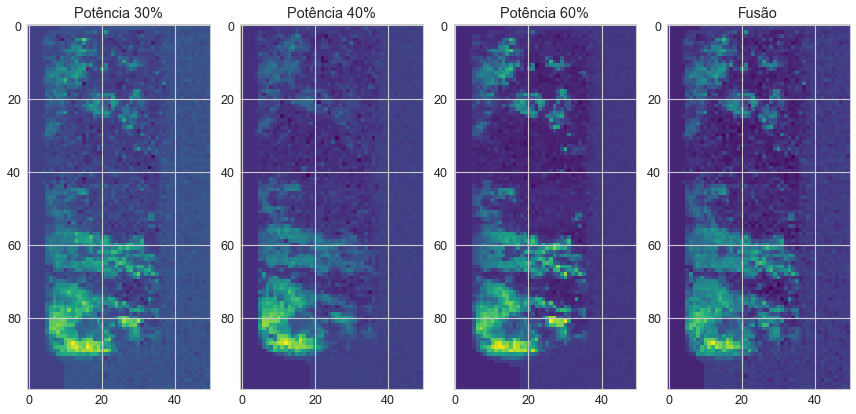

In [22]:
fig,ax=subplots(1,4, figsize = (12, 6))
ax[0].set_title('Potência 30%')
ax[0].imshow(mask_geral[0,:,:,find_index(wavelengths_raman_offset,509)])
ax[1].set_title('Potência 40%')
ax[1].imshow(mask_geral[1,:,:,find_index(wavelengths_raman_offset,509)])
ax[2].set_title('Potência 60%')
ax[2].imshow(mask_geral[2,:,:,find_index(wavelengths_raman_offset,509)])
ax[3].set_title('Fusão')
ax[3].imshow(final_mask[:,:,find_index(wavelengths_raman_offset,509)])
fig.tight_layout()
#savefig('Fused image_albite.jpg',dpi=500)

In [29]:
pro_data_norm_geral.shape

(3, 100, 50, 1024)

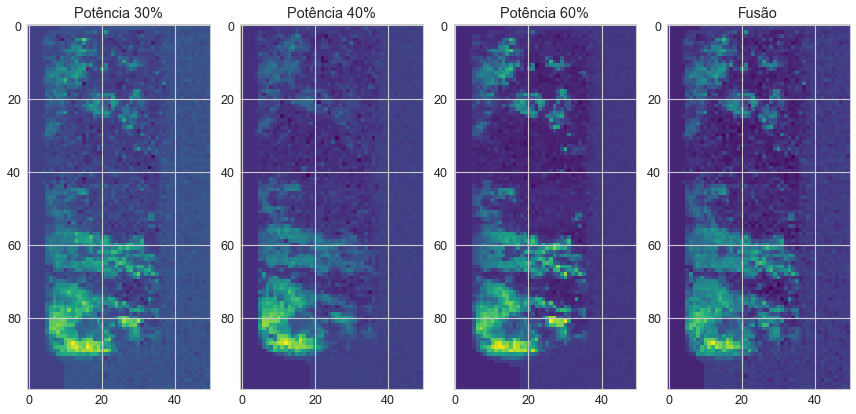

In [30]:
fig,ax=subplots(1,4, figsize = (12, 6))
ax[0].set_title('Potência 30%')
ax[0].imshow(pro_data_norm_geral[0,:,:,find_index(wavelengths_raman,509)])
ax[1].set_title('Potência 40%')
ax[1].imshow(pro_data_norm_geral[1,:,:,find_index(wavelengths_raman,509)])
ax[2].set_title('Potência 60%')
ax[2].imshow(pro_data_norm_geral[2,:,:,find_index(wavelengths_raman,509)])
ax[3].set_title('Fusão')
ax[3].imshow(final_mask[:,:,find_index(wavelengths_raman_offset,509)])
fig.tight_layout()

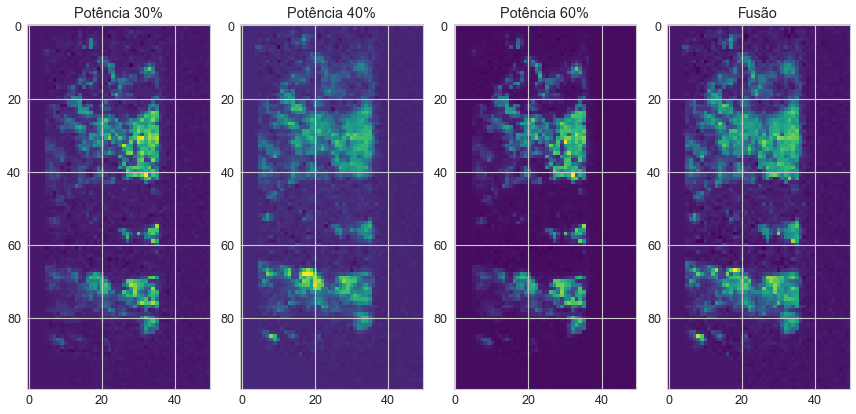

In [21]:
fig,ax=subplots(1, 4, figsize = (12, 6))
ax[0].set_title('Potência 30%')
ax[0].imshow(mask_geral[0,:,:,find_index(wavelengths_raman_offset,464)])
ax[1].set_title('Potência 40%')
ax[1].imshow(mask_geral[1,:,:,find_index(wavelengths_raman_offset,464)])
ax[2].set_title('Potência 60%')
ax[2].imshow(mask_geral[2,:,:,find_index(wavelengths_raman_offset,464)])
ax[3].set_title('Fusão')
ax[3].imshow(final_mask[:,:,find_index(wavelengths_raman_offset,464)])
fig.tight_layout()
# savefig('Fused image_quartzo.jpg',dpi=500)

## Classificação

In [52]:
final_mask.shape

(100, 50, 297)

<IPython.core.display.Javascript object>


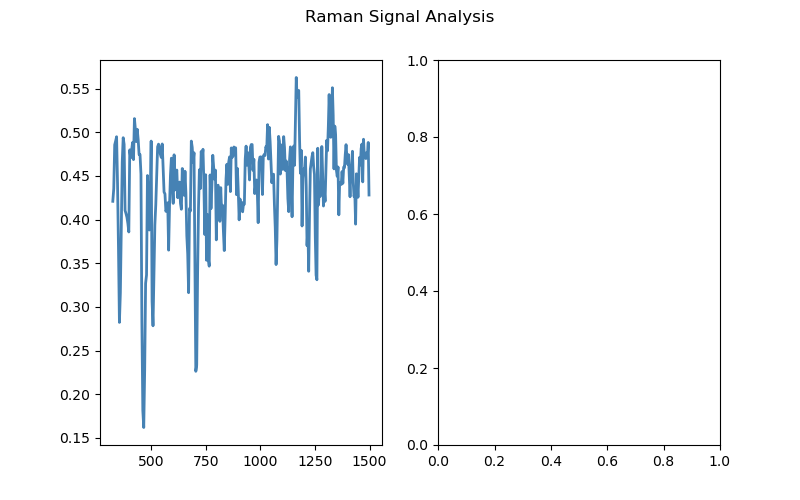

NameError: name 'wavelengths' is not defined

In [53]:
%matplotlib notebook
mean_signal = np.mean(final_mask, axis=(0,1))
min_signal = np.min(final_mask, axis=(0,1))
max_signal = np.max(final_mask, axis=(0,1))



fig,ax = plt.subplots(1,2,figsize=[8,5],gridspec_kw={'width_ratios':[0.9,0.9]})
fig.suptitle('Raman Signal Analysis')
ax[0].plot(wavelengths_raman,mean_signal,lw=2,ls='-',color='steelblue',label='Mean')
ax[0].fill_between(wavelengths,min_signal,max_signal,color='steelblue',alpha=0.2,label='Min-Max')
wn=120
line = ax[0].axvline(wavelengths_raman[wn],lw='1',alpha=0.5,color='red',label='Mapped Wavenumber')
ax[0].set_xlabel(r'Wavenumber $(cm^-1)$')
ax[0].set_ylabel(r'Intensity (arb.un.)')
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),ncol=2, fancybox=True, shadow=True)

ax0 = ax[0].twinx()


minerals = {
    'Petalite':[491.3],
    'Quartz':[463.92],
    'Spodumene':[704.5],
    'Albite':[508.1],
    'Background':[733.1]}



mineral_list = list(minerals.keys())
for i,mineral in enumerate(mineral_list):
    print(mineral)
    try:
        wl,spec = read_ref(mineral)
        ax0.plot(wl, 1 + 0.2*i + 0.5 * spec/np.max(spec),lw=1,color=cm.viridis((i+1)/len(mineral_list)),label=mineral)
    except:
        print(mineral + ' not found')
ax0.set_ylim(0,1+0.2*(i+1)+1)
ax0.set_xlim(200,1500)
    
ax0.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0),ncol=2, fancybox=True, shadow=True)
plt.sca(ax[0])



ax[1].imshow(np.transpose(final_mask[:,:,wn]),cmap=cm.gist_earth,extent=[0,exp_properties['step_size']*exp_properties['n_points'][0],
                                                        0,exp_properties['step_size']*exp_properties['n_points'][1]])
ax[1].set_xlabel(r'$x(mm)$')
ax[1].set_ylabel(r'$y(mm)$')


def update_map(wn):
    im = ax[1].imshow(np.transpose(final_mask[:,:,wn]),cmap=cm.inferno,
                    #   extent=[0,exp_properties['step_size']*exp_properties['n_points'][0],
                    #         0,exp_properties['step_size']*exp_properties['n_points'][1]],
                     interpolation='gaussian')
    line.set_xdata(wavelengths[wn])

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths,ix)
    if event.inaxes == ax[0] or event.inaxes == ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)


fig.tight_layout()